In [1]:
import os
import sys
import subprocess
root = "/data/luojaa/eukgen/"
%cd {root}
sys.path.append(root)
import pandas as pd
import altair as alt
#import altair_saver

import ete3
from ete3 import Tree, TreeStyle, TextFace

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run /data/luojaa/eukgen/styling_and_visualisation.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

/vf/users/luojaa/eukgen


/tmp/ipykernel_160429/542040546.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
os.environ['QT_QPA_PLATFORM']='offscreen'

### read in aggregate files

In [3]:
tree_data = pd.read_csv("/data/tobiassonva/data/eukgen/microcosm_tree_data.tsv", sep = "\t")
leaf_mapping = pd.read_csv("/data/tobiassonva/data/eukgen/microcosm_tree_data.leaf_mapping.tsv", sep = "\t")
header_mapping = pd.read_csv("/data/tobiassonva/data/eukgen/core_data/euk72_ep/euk72_ep.fasta.header_mapping", sep = "\t", header = None)
header_mapping.rename(columns = {0: "acc", 1:"header"}, inplace = True)
header_mapping.set_index("acc", inplace = True)

In [4]:
# not all microcosms are annotated, and not all annotated clusters made it to microcosms
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)

In [5]:
# filter out unannotated microcosms
tree_data.set_index("tree_name", inplace = True)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()
leaf_mapping.set_index("tree_name", inplace = True)
leaf_mapping_annot = leaf_mapping[leaf_mapping.index.isin(annotated_clusters)]
header_mapping_annot = header_mapping[header_mapping.index.isin(set(leaf_mapping_annot.acc))]

In [6]:
# map KOG annotations to tree data
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left").drop("Unnamed: 0", axis = 1)

In [7]:
# read in the kegg maps and modules
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]


FileNotFoundError: [Errno 2] No such file or directory: '/data/luojaa/kegg/kegg_categories.tsv'

### ribosomal analysis

In [8]:
# ribosomal structural proteins
ribosome = pathway_data[pathway_data.CATEGORY_ID == "map03010"].KOGID

In [9]:
# ribosome biogenesis
ribosome_biogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID

In [10]:
eukprofiles_ribosome = kegg_annot[kegg_annot.Target.isin(ribosome)]
microcosms_ribosome = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_ribosome.Query)]

In [11]:
eukprofiles_ribosome.shape[0], len(set(microcosms_ribosome.tree_name))

(8225, 308)

which ribosome KOGs didn't find a microcosm


In [12]:
hits_microcosms_ribosome = eukprofiles_ribosome[eukprofiles_ribosome.Query.isin(set(microcosms_ribosome.tree_name))]
KOGs_rib_inmicrocosms = set(hits_microcosms_ribosome.Target)

In [13]:
len(KOGs_rib_inmicrocosms), len(ribosome)

(113, 136)

In [14]:
ribKOGs_notfound = set(ribosome).difference(KOGs_rib_inmicrocosms)

In [15]:
# # ribosome KOGs that have no microcosms
#category_data[category_data.KOGID.isin(ribKOGs_notfound)].drop_duplicates("FUNCTION")

### translation factor analysis

In [16]:
# translation_factors = set(initiation + elongation + release + prokaryotic_transfact)
# eukprofiles_transfac = kegg_annot[kegg_annot.Target.isin(translation_factors)]
# microcosms_transfac = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_transfac.Query)]

In [17]:
# eukprofiles_transfac.shape[0], len(set(microcosms_transfac.tree_name))

### ribosome biogenesis analysis

In [18]:
eukprofiles_rib_biogen = kegg_annot[kegg_annot.Target.isin(ribosome_biogen)]
microcosms_rib_biogen = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rib_biogen.Query)]

In [19]:
eukprofiles_rib_biogen.shape[0], len(set(microcosms_rib_biogen.tree_name))

(6139, 386)

### nuclear pore complex analysis

In [20]:
# nuclear pore
nuclear_pore = pathway_data[pathway_data.CATEGORY_ID == "map03013"].KOGID
eukprofiles_nucpore = kegg_annot[kegg_annot.Target.isin(nuclear_pore)]
microcosms_nucpore = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_nucpore.Query)]

In [21]:
eukprofiles_nucpore.shape[0], len(set(microcosms_nucpore.tree_name))

(15915, 514)

### look at individual trees for pathways

In [22]:
# ribosome
tree_data_filt = tree_data_mapped[tree_data_mapped["c-ELW"] > 0]
trees = tree_data_filt[tree_data_filt["Target"].isin(ribosome)]
trees_sorted = trees.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
systems = iter(trees_sorted.iloc[30:,:].tree_name)

In [23]:
# nuclear pore
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(nuclear_pore)]
systems = iter(trees_sorted[trees_sorted.Description.str.contains("Nup")].tree_name)


In [24]:
# # release
# tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
# trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(release)]
# systems = iter(trees_sorted.tree_name)


In [25]:
# aa-tRNA biosynthesis
aa_trna = pathway_data[pathway_data.CATEGORY_ID == "map00970"].KOGID
eukprofiles_aatrna = kegg_annot[kegg_annot.Target.isin(aa_trna)]
microcosms_aatrna = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_aatrna.Query)]
print(eukprofiles_aatrna.shape[0], len(set(microcosms_aatrna.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(aa_trna)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"] > .5]
systems = iter(trees_filtered.tree_name)


3731 224


In [26]:
# is110s
#is110s = pathway_data[pathway_data.CATEGORY_ID == "map00970"].KOGID
eukprofiles_is110 = kegg_annot[kegg_annot.Target == "K07485"]
microcosms_is110 = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_is110.Query)]
print(eukprofiles_is110.shape[0], len(set(microcosms_is110.tree_name)))
#tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_mapped[tree_data_mapped.Target == "K07485"]
#trees_filtered = trees_sorted[trees_sorted["c-ELW"] > .5]
systems = iter(trees_sorted.index)

19 1


In [27]:
# mRNA surveillance 
mRNAsurv = pathway_data[pathway_data.CATEGORY_ID == "map03015"].KOGID
eukprofiles_msurv = kegg_annot[kegg_annot.Target.isin(mRNAsurv)]
microcosms_msurv = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_msurv.Query)]
print(eukprofiles_msurv.shape[0], len(set(microcosms_msurv.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(mRNAsurv)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.50,1)]
systems = iter(trees_filtered.tree_name)


6329 344


In [28]:
# ribosome biogenesis 
"map03008"
rBiogen = pathway_data[pathway_data.CATEGORY_ID == "map03008"].KOGID
eukprofiles_rbg = kegg_annot[kegg_annot.Target.isin(rBiogen)]
microcosms_rbg = tree_data_annot[tree_data_annot.tree_name.isin(eukprofiles_rbg.Query)]
print(eukprofiles_rbg.shape[0], len(set(microcosms_rbg.tree_name)))
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_sorted = tree_data_tophit[tree_data_tophit["Target"].isin(rBiogen)]
trees_filtered = trees_sorted[trees_sorted["c-ELW"].between(.501,.99)]
systems = iter(trees_sorted[70:].tree_name)


6139 386


In [29]:
# spliceosome 
"map03040"
splice = pathway_data[pathway_data.CATEGORY_ID == "map03040"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(splice)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(splice)]
trees_cELW = trees_sorted[trees_sorted["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

702 107 5


In [ ]:
# ER
"map04141"
er = pathway_data[pathway_data.CATEGORY_ID == "map03060"].KOGID
tree_data_tophit = tree_data_mapped.sort_values(["Score"], ascending = False).reset_index().drop_duplicates("tree_name").sort_values(["Description"], ascending = False)
trees_unfiltered = tree_data_mapped[tree_data_mapped["Target"].isin(er)]
trees_filtered = tree_data_tophit[tree_data_tophit["Target"].isin(er)]
trees_cELW = trees_sorted[trees_sorted["c-ELW"].between(.501,.99)]
systems = iter(trees_filtered.tree_name)
print(len(set(trees_unfiltered.index)), len(set(trees_filtered.index)), len(set(trees_cELW.tree_name)))

In [30]:
len(trees_filtered), len(trees_sorted)

(107, 119)

In [31]:
a = set(splice).difference(set(tree_data_mapped.Target))

In [32]:
b = set(splice).difference(set(trees_sorted.Target))
c = b.difference(a)

In [33]:
len(set(splice)), len(set(trees_sorted.Target)), len(b)

(118, 37, 117)

In [34]:
len(b), len(a)

(117, 70)

In [35]:
"K13110" in set(splice)

False

In [38]:
#systems = iter(set(trees_unfiltered[trees_unfiltered.Target == "K12857"].index))

EP01137P001952
{'K22384': 'tail-anchored protein insertion receptor', 'K21891': 'calcium load-activated calcium channel'}
System EP01137P001952 has Eukaryotic clades ['EP00839P002823']
/data/tobiassonva/data/eukgen/processing/microcosm/EP01137P001952/EP01137P001952.merged.fasta.muscle.treefile.annot


QStandardPaths: error creating runtime directory '/run/user/61268' (Permission denied)


rendered
Tree has 30 leaves


alt.Chart(...)

,euk_clade_rep,prok_clade_rep,prok_taxa,raw_stem_length,stem_length,bp-RELL,bp-RELL_accept,p-KH,p-KH_accept,p-SH,p-SH_accept,c-ELW,c-ELW_accept,p-AU,p-AU_accept,Target,Score,Description,Pairwise_cov
tree_name,,,,,,,,,,,,,,,,,,,
EP01137P001952,EP00839P002823,WP_015752855_1,Thermodesulfobacteriota,0.070125,0.034734,0.9160,+,0.9150,+,1.0000,+,0.9060,+,0.9130,+,K22384,251.5,tail-anchored protein insertion receptor,0.758427
EP01137P001952,EP00839P002823,WP_015752855_1,Thermodesulfobacteriota,0.070125,0.034734,0.9160,+,0.9150,+,1.0000,+,0.9060,+,0.9130,+,K21891,51.0,calcium load-activated calcium channel,0.697297
EP01137P001952,EP00839P002823,JAHQWU010000139.1_13,Asgard,0.123510,0.061176,0.0416,-,0.0846,+,0.0846,+,0.0469,+,0.0875,+,K22384,251.5,tail-anchored protein insertion receptor,0.758427
EP01137P001952,EP00839P002823,JAHQWU010000139.1_13,Asgard,0.123510,0.061176,0.0416,-,0.0846,+,0.0846,+,0.0469,+,0.0875,+,K21891,51.0,calcium load-activated calcium channel,0.697297
EP01137P001952,EP00839P002823,WP_100906047_1,Euryarchaeota,0.123510,0.061176,0.0424,+,0.0846,+,0.0846,+,0.0469,-,0.0879,+,K22384,251.5,tail-anchored protein insertion receptor,0.758427
EP01137P001952,EP00839P002823,WP_100906047_1,Euryarchaeota,0.123510,0.061176,0.0424,+,0.0846,+,0.0846,+,0.0469,-,0.0879,+,K21891,51.0,calcium load-activated calcium channel,0.697297


alt.VConcatChart(...)

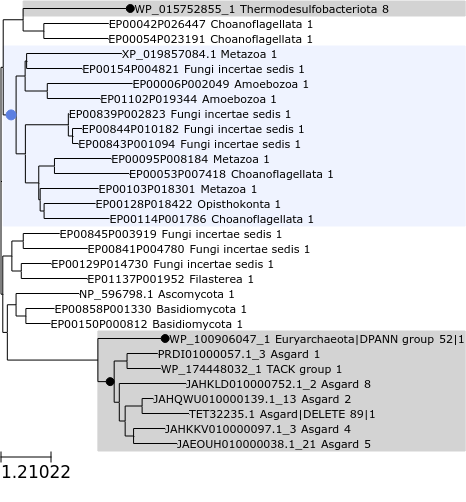

In [39]:
microcosm_path = '/data/tobiassonva/data/eukgen/processing/microcosm/'
system = next(systems)
#system = "EP00755P025418"
print(system)


data = tree_data_mapped.loc[[system]].sort_values(by='c-ELW', ascending=False)
kogs, functions = data.Target, data.Description
print(dict(zip(kogs, functions)))
    
clades = data.euk_clade_rep.unique()
print(f'System {system} has Eukaryotic clades {clades}')

clade = clades[0]

plot_data = data[data.euk_clade_rep == clade]

dist_bar = alt.Chart(data, title=f'{system}: {clade}').mark_bar().encode(
    x = alt.X('prok_taxa', sort=None, axis=alt.Axis(labelAngle=-45)),
    y = alt.Y('top_dist'),
    color = alt.Color('prok_taxa:O'),
    tooltip = alt.Tooltip(['top_dist', 'prok_clade_weight', 'prok_clade_size', 'prok_clade_rep', 'prok_leaf_clade'])
)

print(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
annot_tree, tree_img = color_tree(tree, view_in_notebook=True)


from core_functions.altair_plots import plot_alignment
aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'

#leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
leaf_names = [leaf.name for leaf in tree.get_leaves()]

plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)

print(f'Tree has {len(leaf_names)} leaves')
display(dist_bar)
display(data.iloc[:,[0,4,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])
#display(pd.DataFrame(CDD_annot.loc[system]))
display(plot)
display(tree_img)

In [40]:
header_mapping_annot[header_mapping_annot.index.isin(data.index)]

,header
acc,
EP01137P001952,no_header


### filter pathways and look at top sister clades

In [41]:
# number of microcosms with this pathway
len(set(trees_filtered.index))


87

In [42]:
# all sister clades
trees_filtered.sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

prok_taxa
Actinomycetota             16
Asgard                     15
Bacillota                  12
Gammaproteobacteria         7
FCB group                   6
Euryarchaeota               5
PVC group                   5
Cyanobacteriota             4
DELETE                      4
Thermodesulfobacteriota     3
Betaproteobacteria          2
TACK group                  2
Chloroflexota               2
Mycoplasmatota              2
Thermoplasmata              1
Alphaproteobacteria         1
Name: count, dtype: int64

In [43]:
# all sister clades with high c-ELW
trees_sorted[trees_sorted["c-ELW"].between(.5,.999)].sort_values("c-ELW", ascending = False).drop_duplicates("euk_clade_rep")["prok_taxa"].value_counts()

prok_taxa
PVC group              4
Actinomycetota         2
Alphaproteobacteria    1
TACK group             1
Euryarchaeota          1
Asgard                 1
Myxococcota            1
Name: count, dtype: int64

In [44]:
ribosome_lsu = ['K02925',
'K02930',
'K02932',
'K02934',
'K02937',
'K02936',
'K02938',
'K02940',
'K02866',
'K02865',
'K02868',
'K02870',
'K02873',
'K02872',
'K02875',
'K02877',
'K02880',
'K02883',
'K02882',
'K02885',
'K02889',
'K02891',
'K02894',
'K02893',
'K02896',
'K02898',
'K02901',
'K02900',
'K02903',
'K02905',
'K02908',
'K02910',
'K02912',
'K02915',
'K02918',
'K02917',
'K02920',
'K02922',
'K02921',
'K02923',
'K02924',
'K02927',
'K02928',
'K02929',
'K02941',
'K02942',
'K02943']

initiation = """K02519
K02520
K03113
K03236
K03237
K03238
K03239
K03240
K03241
K03242
K03243
K03245
K03246
K03247
K03248
K03249
K03250
K03251
K03252
K03253
K03254
K03255
K03257
K03258
K03259
K03260
K03261
K03262
K03263
K03264
K03680
K03754
K06158
K06184
K13025
K15026
K15027
K15028
K15029
K15030
K15908
K18995
K19036
K23325
K24086""".split("\n")
elongation = """K00586
K02355
K02357
K02358
K03231
K03232
K03233
K03234
K03235
K03833
K06927
K07561
K15410
K15455
K17866
K17867
K17868
K17878
K19539
K21803
K22696
K22855
K22856
K22857
K24887
K25166""".split("\n")
release = """K03265
K03267
K15031
K15033
K02835
K02838
K02493
K19589
K15448
K01056
K04794""".split("\n")

prokaryotic_transfact = """K01056
K02355
K02356
K02357
K02358
K02493
K02518
K02519
K02520
K02835
K02836
K02837
K02838
K02839
K03833
K04568
K04794
K09890
K09906
K15034
K19810""".split("\n")

In [45]:
set(prokaryotic_transfact).difference(set(initiation + elongation + release))

{'K02356',
 'K02518',
 'K02836',
 'K02837',
 'K02839',
 'K04568',
 'K09890',
 'K09906',
 'K15034',
 'K19810'}

In [46]:
len(prokaryotic_transfact)

21